<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Evaluation-of-TPC-H-Benchmarking-Throughput" data-toc-modified-id="Evaluation-of-TPC-H-Benchmarking-Throughput-1">Evaluation of TPC-H Benchmarking Throughput</a></span><ul class="toc-item"><li><span><a href="#Import-some-libraries" data-toc-modified-id="Import-some-libraries-1.1">Import some libraries</a></span></li></ul></li><li><span><a href="#Load-Results" data-toc-modified-id="Load-Results-2">Load Results</a></span><ul class="toc-item"><li><span><a href="#Load-Results-and-Generate-Common-DataFrame" data-toc-modified-id="Load-Results-and-Generate-Common-DataFrame-2.1">Load Results and Generate Common DataFrame</a></span></li><li><span><a href="#Results-in-Format-&quot;time&quot;" data-toc-modified-id="Results-in-Format-&quot;time&quot;-2.2">Results in Format "time"</a></span></li><li><span><a href="#Results-in-Format-&quot;Throughput&quot;" data-toc-modified-id="Results-in-Format-&quot;Throughput&quot;-2.3">Results in Format "Throughput"</a></span></li></ul></li><li><span><a href="#Loading-Phase" data-toc-modified-id="Loading-Phase-3">Loading Phase</a></span><ul class="toc-item"><li><span><a href="#Plot-Throughput" data-toc-modified-id="Plot-Throughput-3.1">Plot Throughput</a></span></li><li><span><a href="#Plot-Time" data-toc-modified-id="Plot-Time-3.2">Plot Time</a></span></li><li><span><a href="#Plot-Indexing" data-toc-modified-id="Plot-Indexing-3.3">Plot Indexing</a></span></li><li><span><a href="#Plot-Constraints" data-toc-modified-id="Plot-Constraints-3.4">Plot Constraints</a></span></li><li><span><a href="#Plot-Statistics" data-toc-modified-id="Plot-Statistics-3.5">Plot Statistics</a></span></li></ul></li><li><span><a href="#Benchmarking-Phase" data-toc-modified-id="Benchmarking-Phase-4">Benchmarking Phase</a></span><ul class="toc-item"><li><span><a href="#Plot-Throughput" data-toc-modified-id="Plot-Throughput-4.1">Plot Throughput</a></span></li><li><span><a href="#Plot-Hardware-Metrics" data-toc-modified-id="Plot-Hardware-Metrics-4.2">Plot Hardware Metrics</a></span></li></ul></li></ul></div>

# Evaluation of TPC-H Benchmarking Throughput

<img src="https://raw.githubusercontent.com/Beuth-Erdelt/Benchmark-Experiment-Host-Manager/master/docs/workflow-sketch-simple.png"/>

## Import some libraries

In [23]:
from dbmsbenchmarker import *
import pandas as pd
pd.set_option("display.max_rows", None)
pd.set_option('display.max_colwidth', None)

# Some plotly figures
import plotly.graph_objects as go
import plotly.figure_factory as ff
import matplotlib.pyplot as plt

# Some nice output
from IPython.display import display, Markdown

import logging
logging.basicConfig(level=logging.INFO)

import re

def natural_sort(l): 
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)', key)]
    return sorted(l, key=alphanum_key)

%matplotlib inline

In [41]:
# path of folder containing experiment results
resultfolder = "/home/perdelt/benchmarks/"

# create evaluation object for result folder
evaluate = inspector.inspector(resultfolder)

# list of experiments to be combined
# 10, 12, 13, 14, 15, 19, 22, 23, 24, 25, 27, 28, 29, 2, 36, 3, 4, 5, 11, 17, 21, 34
codes = [
    1745592472, # 10
    1745596072, # 11
    1745599672, # 12
    1745603272, # 13
    1745606872, # 14
    1745610472, # 15
    1745614072, # 17
    1745617672, # 19
    1745624872, # 21
    1745628472, # 22
    1745826667, # 23
    1745635672, # 24
    1745639272, # 25
    1745642872, # 27
    1745646472, # 28
    1745650072, # 29
    1745621272, # 2
    1745657272, # 34
    1745660872, # 36
    1745653672, # 3
    1745664472, # 4
    1745668072, # 5
    ]

# Load Results

In [42]:
import ast
import json
import statistics
import pandas as pd

def generate_df(code):
    global SF, dbms, imported, portion_of_data
    path=resultfolder
    with open(path+str(code)+"/connections.config",'r') as inf:
        connections = ast.literal_eval(inf.read())
    #print("found", len(connections), "connections")
    connections_sorted = sorted(connections, key=lambda c: c['name'])
    # loading
    evaluate.load_experiment(code)
    df = evaluate.get_loading_metrics('total_cpu_memory_cached')
    df = df.T.max().sort_index()
    df = pd.DataFrame(df)
    hw_memory = df[0]
    df = evaluate.get_loading_metrics('total_cpu_util_s')
    df = df.T.max().sort_index() - df.T.min().sort_index()
    df = pd.DataFrame(df)
    hw_cpu = df[0]
    # benchmarking
    df = evaluate.get_streaming_metrics('total_cpu_memory_cached')
    df = df.T.max().sort_index()
    df = pd.DataFrame(df)
    hw_memory_stream = df[0]
    df = evaluate.get_streaming_metrics('total_cpu_util_s')
    df = df.T.max().sort_index() - df.T.min().sort_index()
    df = pd.DataFrame(df)
    hw_cpu_stream = df[0]
    # data generator
    df = evaluate.get_datagenerator_metrics('total_cpu_memory_cached')
    df = df.T.max().sort_index()
    df = pd.DataFrame(df)
    hw_memory_datagenerator = df[0]
    #print(hw_memory_datagenerator)
    df = evaluate.get_datagenerator_metrics('total_cpu_util_s')
    df = df.T.max().sort_index() - df.T.min().sort_index()
    df = pd.DataFrame(df)
    hw_cpu_datagenerator = df[0]
    # loader
    df = evaluate.get_loader_metrics('total_cpu_memory_cached')
    df = df.T.max().sort_index()
    df = pd.DataFrame(df)
    hw_memory_loader = df[0]
    df = evaluate.get_loader_metrics('total_cpu_util_s')
    df = df.T.max().sort_index() - df.T.min().sort_index()
    df = pd.DataFrame(df)
    hw_cpu_loader = df[0]
    # benchmarker
    df = evaluate.get_benchmarker_metrics('total_cpu_memory_cached')
    df = df.T.max().sort_index()
    df = pd.DataFrame(df)
    hw_memory_benchmarker = df[0]
    df = evaluate.get_benchmarker_metrics('total_cpu_util_s')
    df = df.T.max().sort_index() - df.T.min().sort_index()
    df = pd.DataFrame(df)
    hw_cpu_benchmarker = df[0]
    # benchmark
    df = evaluate.get_aggregated_experiment_statistics(type='timer', name='run', query_aggregate='Mean', total_aggregate='Mean')
    df_mean = (df/1000.0).sort_index()
    #print(df_mean)
    df = evaluate.get_aggregated_experiment_statistics(type='timer', name='run', query_aggregate='Median', total_aggregate='Geo')
    df_geo = (df/1000.0).sort_index()
    #print(df_geo)
    #df_metric[0]['PostgreSQL-BHT-1-1-1']
    #df_metric.plot()
    #pretty_connections = json.dumps(connections, indent=2)
    df_merged_time = pd.DataFrame()
    df_merged_tpx = pd.DataFrame()
    for c in connections_sorted:
        #print(c)
        connection_name = c['name']
        orig_name = c['orig_name']
        #print(connection_name, orig_name)
        properties = evaluate.get_experiment_connection_properties(connection_name)
        dbms = properties['docker']
        #print(properties)
        # load
        if orig_name in hw_cpu:
            hw_cpu_c = hw_cpu[orig_name]
        else:
            hw_cpu_c = 0
        if orig_name in hw_memory:
            hw_memory_c = hw_memory[orig_name]
        else:
            hw_memory_c = 0
        # stream
        if orig_name in hw_cpu_stream:
            hw_cpu_stream_c = hw_cpu_stream[orig_name]
        else:
            hw_cpu_stream_c = 0
        if orig_name in hw_memory_stream:
            hw_memory_stream_c = hw_memory_stream[orig_name]
        else:
            hw_memory_stream_c = 0
        # loader
        if orig_name in hw_cpu_loader:
            hw_cpu_loader_c = hw_cpu_loader[orig_name]
        else:
            hw_cpu_loader_c = 0
        if orig_name in hw_memory_loader:
            hw_memory_loader_c = hw_memory_loader[orig_name]
        else:
            hw_memory_loader_c = 0
        # data generator
        if orig_name in hw_cpu_datagenerator:
            hw_cpu_datagenerator_c = hw_cpu_datagenerator[orig_name]
        else:
            hw_cpu_datagenerator_c = 0
        if orig_name in hw_memory_datagenerator:
            hw_memory_datagenerator_c = hw_memory_datagenerator[orig_name]
        else:
            hw_memory_datagenerator_c = 0
        # benchmarker
        if orig_name in hw_cpu_benchmarker:
            hw_cpu_benchmarker_c = hw_cpu_benchmarker[orig_name]
        else:
            hw_cpu_benchmarker_c = 0
        if orig_name in hw_memory_benchmarker:
            hw_memory_benchmarker_c = hw_memory_benchmarker[orig_name]
        else:
            hw_memory_benchmarker_c = 0
        results = dict()
        eva = evaluate.get_experiment_connection_properties(c['name'])
        SF = int(c['parameter']['connection_parameter']['loading_parameters']['SF'])
        if 'TPCH_TABLE' in c['parameter']['connection_parameter']['loading_parameters']:
            TPCH_TABLE = c['parameter']['connection_parameter']['loading_parameters']['TPCH_TABLE']
        else:
            TPCH_TABLE = ''
        imported = TPCH_TABLE
        #print(c['hostsystem'])
        #df['CPU'] = c['hostsystem']['CPU']
        #df['Cores'] = c['hostsystem']['Cores']
        #df['node'] = c['hostsystem']['node']
        if len(c['hostsystem']['loading_timespans']['sensor']) == 0:
            continue
        timespan_load = max([end for (start,end) in c['hostsystem']['loading_timespans']['sensor']]) - min([start for (start,end) in c['hostsystem']['loading_timespans']['sensor']])
        timespan_benchmark = eva['times']['total'][c['name']]['time_end']-eva['times']['total'][c['name']]['time_start']
        results[connection_name] = {
            'load':eva['times']['load_ms']/1000.,
            'ingest':eva['times']['ingest_ms']/1000.,
            'generate':eva['times']['generate_ms']/1000.,
            'schema':eva['times']['schema_ms']/1000.,
            #'index':eva['times']['index_ms']/1000.,
            'loaded':eva['times']['script_times']['loaded'],
            'initschema':eva['times']['script_times']['initschema'],
            'span_load':timespan_load,
            'span_benchmark':timespan_benchmark,
            #'mean_generate': statistics.mean([end-start for (start,end) in c['hostsystem']['loading_timespans']['datagenerator']]),
            #'max_generate': max([end-start for (start,end) in c['hostsystem']['loading_timespans']['datagenerator']]),
            #'min_generate': min([end-start for (start,end) in c['hostsystem']['loading_timespans']['datagenerator']]),
            'mean_load': statistics.mean([end-start for (start,end) in c['hostsystem']['loading_timespans']['sensor']]),
            'max_load': max([end-start for (start,end) in c['hostsystem']['loading_timespans']['sensor']]),
            'min_load': min([end-start for (start,end) in c['hostsystem']['loading_timespans']['sensor']]),
            'span_generate': c['timeGenerate'],
            #'pods': int(c['parameter']['connection_parameter']['loading_parameters']['PODS_PARALLEL']),
            #'indexed':eva['times']['script_times']['indexed'],
            'initindexes':eva['times']['script_times']['initindexes'],
            'initconstraints':eva['times']['script_times']['initconstraints'],
            'initstatistics':eva['times']['script_times']['initstatistics'],
            'benchmark_mean':df_mean.loc[connection_name]['total_timer_run'],
            'benchmark_geo':df_geo.loc[connection_name]['total_timer_run'],
        }
        # DataFrame of time
        df = pd.DataFrame(results).T
        df_time = df.copy()
        df_tpx = df.copy()
        # Compute DataFrame of throughput (Tpx)
        df_tpx = 3600*int(SF)/df_tpx * portion_of_data
        # Set Values that are same for time and tpx
        df_time['SF'] = int(SF)
        df_tpx['SF'] = int(SF)
        df_time['dbms'] = dbms
        df_tpx['dbms'] = dbms
        df_time['TPCH_TABLE'] = TPCH_TABLE
        df_tpx['TPCH_TABLE'] = TPCH_TABLE
        df_time['CPU'] = c['hostsystem']['CPU']
        df_time['Cores'] = c['hostsystem']['Cores']
        df_time['node'] = c['hostsystem']['node']
        df_tpx['CPU'] = c['hostsystem']['CPU']
        df_tpx['Cores'] = c['hostsystem']['Cores']
        df_tpx['node'] = c['hostsystem']['node']
        df_time['pods'] = int(c['parameter']['connection_parameter']['loading_parameters']['PODS_PARALLEL'])
        df_tpx['pods'] = int(c['parameter']['connection_parameter']['loading_parameters']['PODS_PARALLEL'])
        #df_time['threads'] = int(c['parameter']['connection_parameter']['loading_parameters']['MYSQL_LOADING_THREADS'])
        #df_tpx['threads'] = int(c['parameter']['connection_parameter']['loading_parameters']['MYSQL_LOADING_THREADS'])
        df_time['num_experiment'] = int(c['parameter']['numExperiment'])
        df_tpx['num_experiment'] = int(c['parameter']['numExperiment'])
        df_time['num_client'] = int(c['parameter']['client'])
        df_tpx['num_client'] = int(c['parameter']['client'])
        df_time['benchmark_start'] = eva['times']['total'][c['name']]['time_start']
        df_time['benchmark_end'] = eva['times']['total'][c['name']]['time_end']
        df_tpx['benchmark_start'] = eva['times']['total'][c['name']]['time_start']
        df_tpx['benchmark_end'] = eva['times']['total'][c['name']]['time_end']
        df_time['mem_max_load'] = hw_memory_c
        df_tpx['mem_max_load'] = hw_memory_c
        # load
        df_time['mem_max_load'] = hw_memory_c
        df_tpx['mem_max_load'] = hw_memory_c
        df_time['cpu_total_load'] = hw_cpu_c
        df_tpx['cpu_total_load'] = hw_cpu_c
        # stream
        df_time['mem_max_stream'] = hw_memory_stream_c
        df_tpx['mem_max_stream'] = hw_memory_stream_c
        df_time['cpu_total_stream'] = hw_cpu_stream_c
        df_tpx['cpu_total_stream'] = hw_cpu_stream_c
        # loader
        df_time['mem_max_loader'] = hw_memory_loader_c
        df_tpx['mem_max_loader'] = hw_memory_loader_c
        df_time['cpu_total_loader'] = hw_cpu_loader_c
        df_tpx['cpu_total_loader'] = hw_cpu_loader_c
        # data generator
        df_time['mem_max_datagenerator'] = hw_memory_datagenerator_c
        df_tpx['mem_max_datagenerator'] = hw_memory_datagenerator_c
        df_time['cpu_total_datagenerator'] = hw_cpu_datagenerator_c
        df_tpx['cpu_total_datagenerator'] = hw_cpu_datagenerator_c
        # benchmarker
        df_time['mem_max_benchmarker'] = hw_memory_benchmarker_c
        df_tpx['mem_max_benchmarker'] = hw_memory_benchmarker_c
        df_time['cpu_total_benchmarker'] = hw_cpu_benchmarker_c
        df_tpx['cpu_total_benchmarker'] = hw_cpu_benchmarker_c
        df_merged_time = pd.concat([df_merged_time, df_time])
        df_merged_tpx = pd.concat([df_merged_tpx, df_tpx])
    return df_merged_time, df_merged_tpx

def merge_experiments(df_time, df_tpx, code):
    df_time_tmp, df_tpx_tmp = generate_df(code)
    df_time = pd.concat([df_time, df_time_tmp])
    df_tpx = pd.concat([df_tpx, df_tpx_tmp])
    return df_time, df_tpx

## Load Results and Generate Common DataFrame

In [43]:
df_time = pd.DataFrame()
df_tpx = pd.DataFrame()

portion_of_data = 1.0 # for lineitem table = 0.7, for all tables = 1.0

for code in codes:
    df_time, df_tpx = merge_experiments(df_time, df_tpx, code)

## Results in Format "time"

In [44]:
df_time.T

,MonetDB-BHT-8-1-1,MonetDB-BHT-8-2-1,MonetDB-BHT-8-1-1,MonetDB-BHT-8-2-1,MonetDB-BHT-8-1-1,MonetDB-BHT-8-2-1,MonetDB-BHT-8-1-1,MonetDB-BHT-8-2-1,MonetDB-BHT-8-1-1,MonetDB-BHT-8-2-1,...,MonetDB-BHT-8-1-1,MonetDB-BHT-8-2-1,MonetDB-BHT-8-1-1,MonetDB-BHT-8-2-1,MonetDB-BHT-8-1-1,MonetDB-BHT-8-2-1,MonetDB-BHT-8-1-1,MonetDB-BHT-8-2-1,MonetDB-BHT-8-1-1,MonetDB-BHT-8-2-1
load,2105.0,2105.0,1931.0,1931.0,2300.0,2300.0,1959.0,1959.0,2024.0,2024.0,...,888.0,888.0,1008.0,1008.0,1603.0,1603.0,2530.0,2530.0,2516.0,2516.0
ingest,619.0,619.0,520.0,520.0,585.0,585.0,533.0,533.0,523.0,523.0,...,307.0,307.0,646.0,646.0,500.0,500.0,857.0,857.0,801.0,801.0
generate,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0
schema,10.0,10.0,10.0,10.0,9.0,9.0,8.0,8.0,9.0,9.0,...,1.0,1.0,1.0,1.0,2.0,2.0,12.0,12.0,9.0,9.0
loaded,10.0,10.0,10.0,10.0,9.0,9.0,8.0,8.0,9.0,9.0,...,1.0,1.0,1.0,1.0,2.0,2.0,12.0,12.0,9.0,9.0
initschema,10.0,10.0,10.0,10.0,8.0,8.0,8.0,8.0,9.0,9.0,...,1.0,1.0,1.0,1.0,2.0,2.0,12.0,12.0,9.0,9.0
span_load,619.0,619.0,520.0,520.0,585.0,585.0,533.0,533.0,523.0,523.0,...,307.0,307.0,646.0,646.0,500.0,500.0,857.0,857.0,801.0,801.0
span_benchmark,347.0,349.0,346.0,350.0,352.0,357.0,369.0,365.0,356.0,390.0,...,169.0,179.0,170.0,153.0,377.0,371.0,388.0,375.0,397.0,377.0
mean_load,608.25,608.25,499.875,499.875,579.125,579.125,522.75,522.75,515.625,515.625,...,244.25,244.25,618.25,618.25,482.5,482.5,815.375,815.375,754.0,754.0
max_load,619.0,619.0,520.0,520.0,585.0,585.0,532.0,532.0,522.0,522.0,...,307.0,307.0,646.0,646.0,500.0,500.0,857.0,857.0,801.0,801.0


## Results in Format "Throughput"

In [45]:
df_tpx.T

,MonetDB-BHT-8-1-1,MonetDB-BHT-8-2-1,MonetDB-BHT-8-1-1,MonetDB-BHT-8-2-1,MonetDB-BHT-8-1-1,MonetDB-BHT-8-2-1,MonetDB-BHT-8-1-1,MonetDB-BHT-8-2-1,MonetDB-BHT-8-1-1,MonetDB-BHT-8-2-1,...,MonetDB-BHT-8-1-1,MonetDB-BHT-8-2-1,MonetDB-BHT-8-1-1,MonetDB-BHT-8-2-1,MonetDB-BHT-8-1-1,MonetDB-BHT-8-2-1,MonetDB-BHT-8-1-1,MonetDB-BHT-8-2-1,MonetDB-BHT-8-1-1,MonetDB-BHT-8-2-1
load,51.306413,51.306413,55.92957,55.92957,46.956522,46.956522,55.130168,55.130168,53.359684,53.359684,...,121.621622,121.621622,107.142857,107.142857,67.373674,67.373674,42.687747,42.687747,42.925278,42.925278
ingest,174.47496,174.47496,207.692308,207.692308,184.615385,184.615385,202.626642,202.626642,206.500956,206.500956,...,351.791531,351.791531,167.182663,167.182663,216.0,216.0,126.021004,126.021004,134.831461,134.831461
generate,108000.0,108000.0,108000.0,108000.0,108000.0,108000.0,108000.0,108000.0,108000.0,108000.0,...,108000.0,108000.0,108000.0,108000.0,108000.0,108000.0,inf,inf,108000.0,108000.0
schema,10800.0,10800.0,10800.0,10800.0,12000.0,12000.0,13500.0,13500.0,12000.0,12000.0,...,108000.0,108000.0,108000.0,108000.0,54000.0,54000.0,9000.0,9000.0,12000.0,12000.0
loaded,10800.0,10800.0,10800.0,10800.0,12000.0,12000.0,13500.0,13500.0,12000.0,12000.0,...,108000.0,108000.0,108000.0,108000.0,54000.0,54000.0,9000.0,9000.0,12000.0,12000.0
initschema,10800.0,10800.0,10800.0,10800.0,13500.0,13500.0,13500.0,13500.0,12000.0,12000.0,...,108000.0,108000.0,108000.0,108000.0,54000.0,54000.0,9000.0,9000.0,12000.0,12000.0
span_load,174.47496,174.47496,207.692308,207.692308,184.615385,184.615385,202.626642,202.626642,206.500956,206.500956,...,351.791531,351.791531,167.182663,167.182663,216.0,216.0,126.021004,126.021004,134.831461,134.831461
span_benchmark,311.239193,309.455587,312.138728,308.571429,306.818182,302.521008,292.682927,295.890411,303.370787,276.923077,...,639.053254,603.351955,635.294118,705.882353,286.472149,291.105121,278.350515,288.0,272.040302,286.472149
mean_load,177.55857,177.55857,216.054014,216.054014,186.488237,186.488237,206.599713,206.599713,209.454545,209.454545,...,442.169908,442.169908,174.686615,174.686615,223.834197,223.834197,132.454392,132.454392,143.236074,143.236074
max_load,174.47496,174.47496,207.692308,207.692308,184.615385,184.615385,203.007519,203.007519,206.896552,206.896552,...,351.791531,351.791531,167.182663,167.182663,216.0,216.0,126.021004,126.021004,134.831461,134.831461


# Benchmarking Phase

In [46]:
#benchmark_start = df_time.groupby(['node','SF', 'num_experiment', 'num_client']).min('benchmark_start')
benchmark_start = df_time.groupby(['node', 'num_client']).min('benchmark_start')

benchmark_start

load  ingest  generate  schema  loaded  initschema  \
node        num_client                                                         
cl-worker10 1           2105.0   619.0       1.0    10.0    10.0        10.0   
            2           2105.0   619.0       1.0    10.0    10.0        10.0   
cl-worker11 1           1931.0   520.0       1.0    10.0    10.0        10.0   
            2           1931.0   520.0       1.0    10.0    10.0        10.0   
cl-worker12 1           2300.0   585.0       1.0     9.0     9.0         8.0   
            2           2300.0   585.0       1.0     9.0     9.0         8.0   
cl-worker13 1           1959.0   533.0       1.0     8.0     8.0         8.0   
            2           1959.0   533.0       1.0     8.0     8.0         8.0   
cl-worker14 1           2024.0   523.0       1.0     9.0     9.0         9.0   
            2           2024.0   523.0       1.0     9.0     9.0         9.0   
cl-worker15 1           2123.0   665.0       1.0     9.0     9.0         9.0   
            2           2123.0   665.0       1.0     9.0     9.0         9.0   
cl-worker17 1            860.0   297.0       1.0     1.0     1.0         1.0   
            2            860.0   297.0       1.0     1.0     1.0         1.0   
cl-worker19 1            828.0   282.0       0.0     1.0     1.0         1.0   
            2            828.0   282.0       0.0     1.0     1.0         1.0   
cl-worker2  1           1806.0   512.0       1.0     2.0     2.0         2.0   
            2           1806.0   512.0       1.0     2.0     2.0         2.0   
cl-worker21 1            883.0   266.0       1.0     1.0     1.0         1.0   
            2            883.0   266.0       1.0     1.0     1.0         1.0   
cl-worker22 1           1221.0   367.0       1.0     6.0     6.0         6.0   
            2           1221.0   367.0       1.0     6.0     6.0         6.0   
cl-worker23 1            914.0   275.0       0.0     1.0     1.0         1.0   
            2            914.0   275.0       0.0     1.0     1.0         1.0   
cl-worker24 1           1010.0   305.0       1.0     1.0     1.0         1.0   
            2           1010.0   305.0       1.0     1.0     1.0         1.0   
cl-worker25 1           1026.0   309.0       1.0     1.0     1.0         1.0   
            2           1026.0   309.0       1.0     1.0     1.0         1.0   
cl-worker27 1           1711.0   445.0       1.0     1.0     1.0         1.0   
            2           1711.0   445.0       1.0     1.0     1.0         1.0   
cl-worker28 1           1427.0   471.0       1.0     1.0     1.0         1.0   
            2           1427.0   471.0       1.0     1.0     1.0         1.0   
cl-worker29 1           1023.0   387.0       1.0     1.0     1.0         1.0   
            2           1023.0   387.0       1.0     1.0     1.0         1.0   
cl-worker3  1           1603.0   500.0       1.0     2.0     2.0         2.0   
            2           1603.0   500.0       1.0     2.0     2.0         2.0   
cl-worker34 1            888.0   307.0       1.0     1.0     1.0         1.0   
            2            888.0   307.0       1.0     1.0     1.0         1.0   
cl-worker36 1           1008.0   646.0       1.0     1.0     1.0         1.0   
            2           1008.0   646.0       1.0     1.0     1.0         1.0   
cl-worker4  1           2530.0   857.0       0.0    12.0    12.0        12.0   
            2           2530.0   857.0       0.0    12.0    12.0        12.0   
cl-worker5  1           2516.0   801.0       1.0     9.0     9.0         9.0   
            2           2516.0   801.0       1.0     9.0     9.0         9.0   

                        span_load  span_benchmark  mean_load  max_load  ...  \
node        num_client                                                  ...   
cl-worker10 1               619.0           347.0    608.250     619.0  ...   
            2               619.0           349.0    608.250     619.0  ...   
cl-worker11 1               5

In [47]:
#benchmark_end = df_time.groupby(['node','SF', 'num_experiment', 'num_client']).max('benchmark_end')
benchmark_end = df_time.groupby(['node', 'num_client']).max('benchmark_end')

benchmark_end

load  ingest  generate  schema  loaded  initschema  \
node        num_client                                                         
cl-worker10 1           2105.0   619.0       1.0    10.0    10.0        10.0   
            2           2105.0   619.0       1.0    10.0    10.0        10.0   
cl-worker11 1           1931.0   520.0       1.0    10.0    10.0        10.0   
            2           1931.0   520.0       1.0    10.0    10.0        10.0   
cl-worker12 1           2300.0   585.0       1.0     9.0     9.0         8.0   
            2           2300.0   585.0       1.0     9.0     9.0         8.0   
cl-worker13 1           1959.0   533.0       1.0     8.0     8.0         8.0   
            2           1959.0   533.0       1.0     8.0     8.0         8.0   
cl-worker14 1           2024.0   523.0       1.0     9.0     9.0         9.0   
            2           2024.0   523.0       1.0     9.0     9.0         9.0   
cl-worker15 1           2123.0   665.0       1.0     9.0     9.0         9.0   
            2           2123.0   665.0       1.0     9.0     9.0         9.0   
cl-worker17 1            860.0   297.0       1.0     1.0     1.0         1.0   
            2            860.0   297.0       1.0     1.0     1.0         1.0   
cl-worker19 1            828.0   282.0       0.0     1.0     1.0         1.0   
            2            828.0   282.0       0.0     1.0     1.0         1.0   
cl-worker2  1           1806.0   512.0       1.0     2.0     2.0         2.0   
            2           1806.0   512.0       1.0     2.0     2.0         2.0   
cl-worker21 1            883.0   266.0       1.0     1.0     1.0         1.0   
            2            883.0   266.0       1.0     1.0     1.0         1.0   
cl-worker22 1           1221.0   367.0       1.0     6.0     6.0         6.0   
            2           1221.0   367.0       1.0     6.0     6.0         6.0   
cl-worker23 1            914.0   275.0       0.0     1.0     1.0         1.0   
            2            914.0   275.0       0.0     1.0     1.0         1.0   
cl-worker24 1           1010.0   305.0       1.0     1.0     1.0         1.0   
            2           1010.0   305.0       1.0     1.0     1.0         1.0   
cl-worker25 1           1026.0   309.0       1.0     1.0     1.0         1.0   
            2           1026.0   309.0       1.0     1.0     1.0         1.0   
cl-worker27 1           1711.0   445.0       1.0     1.0     1.0         1.0   
            2           1711.0   445.0       1.0     1.0     1.0         1.0   
cl-worker28 1           1427.0   471.0       1.0     1.0     1.0         1.0   
            2           1427.0   471.0       1.0     1.0     1.0         1.0   
cl-worker29 1           1023.0   387.0       1.0     1.0     1.0         1.0   
            2           1023.0   387.0       1.0     1.0     1.0         1.0   
cl-worker3  1           1603.0   500.0       1.0     2.0     2.0         2.0   
            2           1603.0   500.0       1.0     2.0     2.0         2.0   
cl-worker34 1            888.0   307.0       1.0     1.0     1.0         1.0   
            2            888.0   307.0       1.0     1.0     1.0         1.0   
cl-worker36 1           1008.0   646.0       1.0     1.0     1.0         1.0   
            2           1008.0   646.0       1.0     1.0     1.0         1.0   
cl-worker4  1           2530.0   857.0       0.0    12.0    12.0        12.0   
            2           2530.0   857.0       0.0    12.0    12.0        12.0   
cl-worker5  1           2516.0   801.0       1.0     9.0     9.0         9.0   
            2           2516.0   801.0       1.0     9.0     9.0         9.0   

                        span_load  span_benchmark  mean_load  max_load  ...  \
node        num_client                                                  ...   
cl-worker10 1               619.0           347.0    608.250     619.0  ...   
            2               619.0           349.0    608.250     619.0  ...   
cl-worker11 1               5

In [48]:
df_benchmark = pd.DataFrame(benchmark_end['benchmark_end'] - benchmark_start['benchmark_start'])

df_benchmark.columns = ['span_benchmark']

df_benchmark

span_benchmark
node        num_client                
cl-worker10 1                      347
            2                      349
cl-worker11 1                      346
            2                      350
cl-worker12 1                      352
            2                      357
cl-worker13 1                      369
            2                      365
cl-worker14 1                      356
            2                      390
cl-worker15 1                      362
            2                      378
cl-worker17 1                      240
            2                      253
cl-worker19 1                      255
            2                      258
cl-worker2  1                      411
            2                      389
cl-worker21 1                      176
            2                      160
cl-worker22 1                      211
            2                      176
cl-worker23 1                      184
            2                      181
cl-worker24 1                      225
            2                      192
cl-worker25 1                      204
            2                      178
cl-worker27 1                      198
            2                      175
cl-worker28 1                      202
            2                      192
cl-worker29 1                      221
            2                      258
cl-worker3  1                      377
            2                      371
cl-worker34 1                      169
            2                      179
cl-worker36 1                      170
            2                      153
cl-worker4  1                      388
            2                      375
cl-worker5  1                      397
            2                      377

In [49]:
#benchmark_count = df_time.groupby(['node','SF', 'num_experiment', 'num_client']).count()

#benchmark_count

In [50]:
#df_benchmark['count'] = benchmark_count['benchmark_geo']
import re

# Natural sort helpers
def convert(text):
    return int(text) if text.isdigit() else text.lower()

def alphanum_key(key):
    return [convert(c) for c in re.split('([0-9]+)', key)]

def natural_sort_multiindex(index, level=0):
    return sorted(index, key=lambda x: alphanum_key(str(x[level])))
    
# Apply natural sort to index
sorted_index = natural_sort_multiindex(df_benchmark.index, level=0)
df_sorted = df_benchmark.loc[sorted_index]

df_sorted

span_benchmark
node        num_client                
cl-worker2  1                      411
            2                      389
cl-worker3  1                      377
            2                      371
cl-worker4  1                      388
            2                      375
cl-worker5  1                      397
            2                      377
cl-worker10 1                      347
            2                      349
cl-worker11 1                      346
            2                      350
cl-worker12 1                      352
            2                      357
cl-worker13 1                      369
            2                      365
cl-worker14 1                      356
            2                      390
cl-worker15 1                      362
            2                      378
cl-worker17 1                      240
            2                      253
cl-worker19 1                      255
            2                      258
cl-worker21 1                      176
            2                      160
cl-worker22 1                      211
            2                      176
cl-worker23 1                      184
            2                      181
cl-worker24 1                      225
            2                      192
cl-worker25 1                      204
            2                      178
cl-worker27 1                      198
            2                      175
cl-worker28 1                      202
            2                      192
cl-worker29 1                      221
            2                      258
cl-worker34 1                      169
            2                      179
cl-worker36 1                      170
            2                      153

In [51]:
# Average span_benchmark per node (first level of index)
avg_per_node = df_sorted.groupby(level=0).mean()
sorted_index = natural_sort(avg_per_node.index)
avg_per_node = avg_per_node.loc[sorted_index]
avg_per_node

,span_benchmark
node,
cl-worker2,400.0
cl-worker3,374.0
cl-worker4,381.5
cl-worker5,387.0
cl-worker10,348.0
cl-worker11,348.0
cl-worker12,354.5
cl-worker13,367.0
cl-worker14,373.0


<Axes: xlabel='node'>

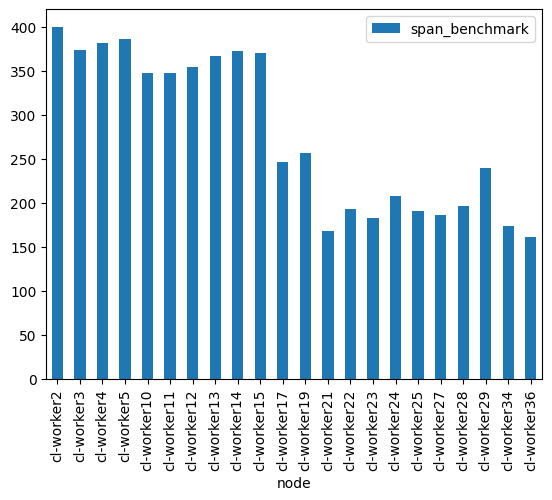

In [52]:
avg_per_node.plot.bar()

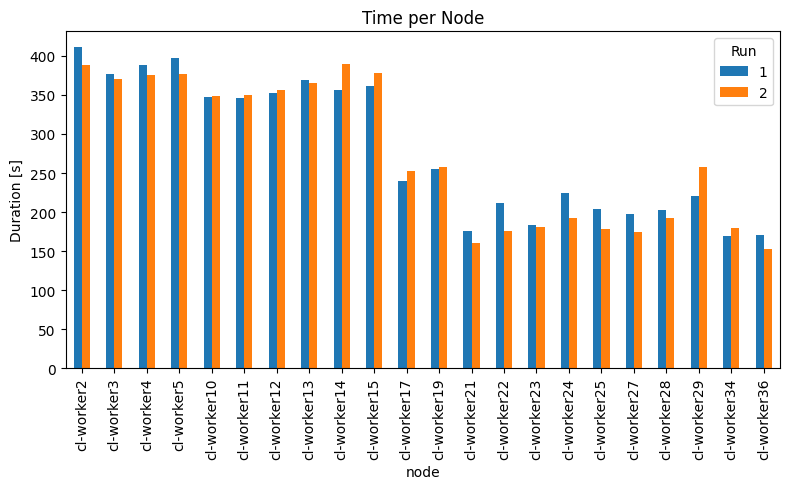

num_client,1,2
node,,
cl-worker2,411,389
cl-worker3,377,371
cl-worker4,388,375
cl-worker5,397,377
cl-worker10,347,349
cl-worker11,346,350
cl-worker12,352,357
cl-worker13,369,365
cl-worker14,356,390


In [53]:
import matplotlib.pyplot as plt

# Unstack so that num_client is on the x-axis and each node is a separate bar
df_unstacked = df_sorted['span_benchmark'].unstack(level=1)
sorted_index = natural_sort(df_unstacked.index)
df_unstacked = df_unstacked.loc[sorted_index]

# Plot the grouped bar chart
df_unstacked.plot(kind='bar', figsize=(8, 5))

plt.ylabel("Duration [s]")
plt.title("Time per Node")
plt.legend(title='Run')
#plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig("time_per_node.png", dpi=300)
plt.show()
df_unstacked

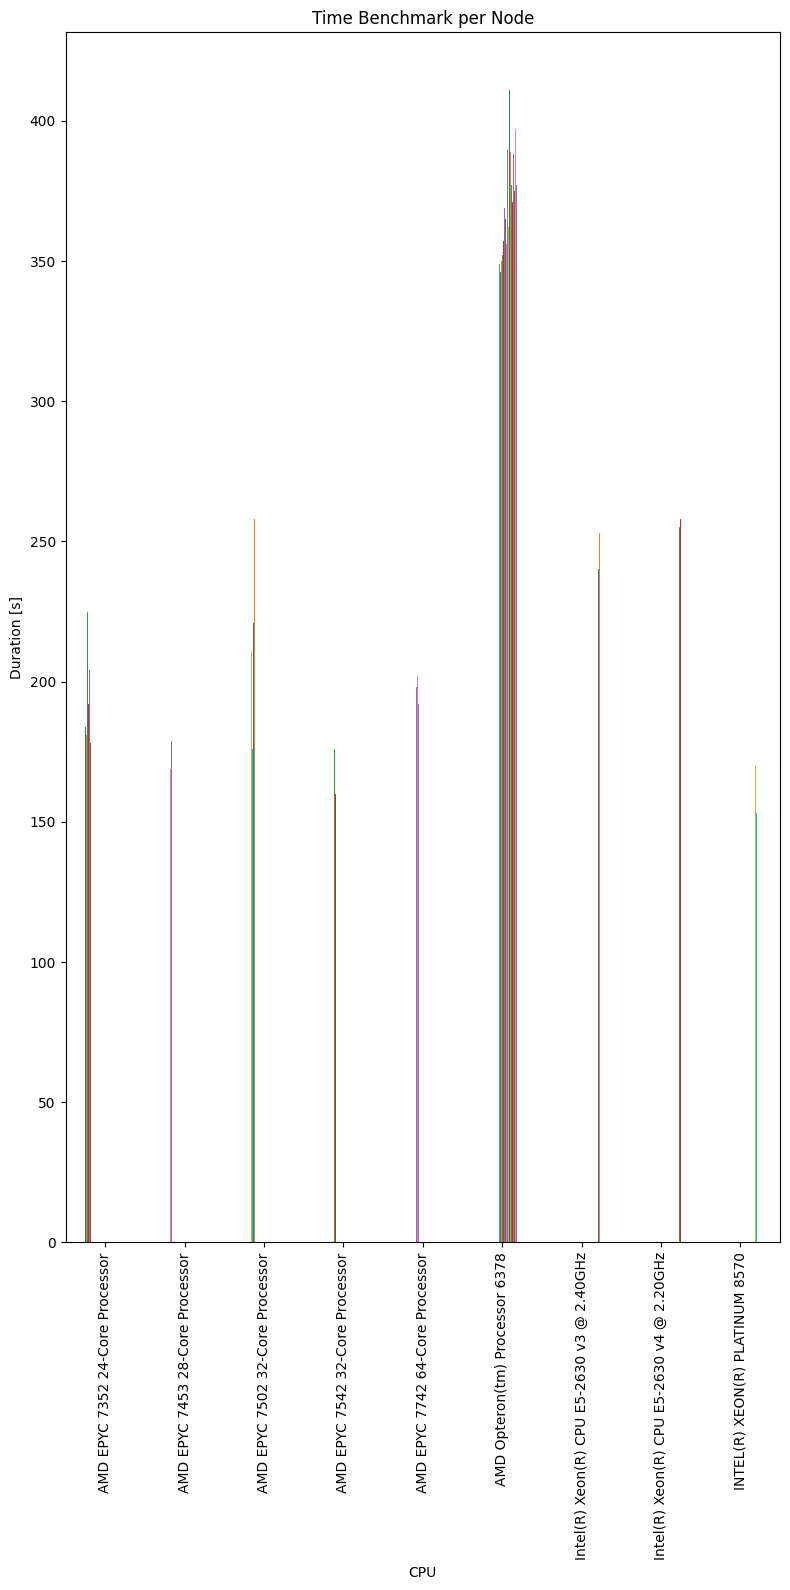

node                                      cl-worker23        cl-worker24  \
num_client                                          1      2           1   
CPU                                                                        
AMD EPYC 7352 24-Core Processor                 184.0  181.0       225.0   
AMD EPYC 7453 28-Core Processor                   NaN    NaN         NaN   
AMD EPYC 7502 32-Core Processor                   NaN    NaN         NaN   
AMD EPYC 7542 32-Core Processor                   NaN    NaN         NaN   
AMD EPYC 7742 64-Core Processor                   NaN    NaN         NaN   
AMD Opteron(tm) Processor 6378                    NaN    NaN         NaN   
Intel(R) Xeon(R) CPU E5-2630 v3 @ 2.40GHz         NaN    NaN         NaN   
Intel(R) Xeon(R) CPU E5-2630 v4 @ 2.20GHz         NaN    NaN         NaN   
INTEL(R) XEON(R) PLATINUM 8570                    NaN    NaN         NaN   

node                                             cl-worker25         \
num_client                                     2           1      2   
CPU                                                                   
AMD EPYC 7352 24-Core Processor            192.0       204.0  178.0   
AMD EPYC 7453 28-Core Processor              NaN         NaN    NaN   
AMD EPYC 7502 32-Core Processor              NaN         NaN    NaN   
AMD EPYC 7542 32-Core Processor              NaN         NaN    NaN   
AMD EPYC 7742 64-Core Processor              NaN         NaN    NaN   
AMD Opteron(tm) Processor 6378               NaN         NaN    NaN   
Intel(R) Xeon(R) CPU E5-2630 v3 @ 2.40GHz    NaN         NaN    NaN   
Intel(R) Xeon(R) CPU E5-2630 v4 @ 2.20GHz    NaN         NaN    NaN   
INTEL(R) XEON(R) PLATINUM 8570               NaN         NaN    NaN   

node                                      cl-worker34        cl-worker22  \
num_client                                          1      2           1   
CPU                                                                        
AMD EPYC 7352 24-Core Processor                   NaN    NaN         NaN   
AMD EPYC 7453 28-Core Processor                 169.0  179.0         NaN   
AMD EPYC 7502 32-Core Processor                   NaN    NaN       211.0   
AMD EPYC 7542 32-Core Processor                   NaN    NaN         NaN   
AMD EPYC 7742 64-Core Processor                   NaN    NaN         NaN   
AMD Opteron(tm) Processor 6378                    NaN    NaN         NaN   
Intel(R) Xeon(R) CPU E5-2630 v3 @ 2.40GHz         NaN    NaN         NaN   
Intel(R) Xeon(R) CPU E5-2630 v4 @ 2.20GHz         NaN    NaN         NaN   
INTEL(R) XEON(R) PLATINUM 8570                    NaN    NaN         NaN   

node                                              ... cl-worker4         \
num_client                                     2  ...          1      2   
CPU                                               ...                     
AMD EPYC 7352 24-Core Processor              NaN  ...        NaN    NaN   
AMD EPYC 7453 28-Core Processor              NaN  ...        NaN    NaN   
AMD EPYC 7502 32-Core Processor            176.0  ...        NaN    NaN   
AMD EPYC 7542 32-Core Processor              NaN  ...        NaN    NaN   
AMD EPYC 7742 64-Core Processor              NaN  ...        NaN    NaN   
AMD Opteron(tm) Processor 6378               NaN  ...      388.0  375.0   
Intel(R) Xeon(R) CPU E5-2630 v3 @ 2.40GHz    NaN  ...        NaN    NaN   
Intel(R) Xeon(R) CPU E5-2630 v4 @ 2.20GHz    NaN  ...        NaN    NaN   
INTEL(R) XEON(R) PLATINUM 8570               NaN  ...        NaN    NaN   

node                                      cl-worker5        cl-worker36  \
num_client                                         1      2           1   
CPU                                                                       
AMD EPYC 7352 24-Core Processor                  NaN    NaN         NaN   
AMD EPYC 7453 28-Core Processor                  NaN    NaN         NaN   
AMD EPYC 7502 32-Core Processor              

In [54]:
benchmark_start = df_time.groupby(['CPU', 'node', 'num_client']).min('benchmark_start')
benchmark_end = df_time.groupby(['CPU', 'node', 'num_client']).max('benchmark_end')
df_benchmark = pd.DataFrame(benchmark_end['benchmark_end'] - benchmark_start['benchmark_start'])
df_benchmark.columns = ['span_benchmark']

#sorted_index = natural_sort_multiindex(df_benchmark.index, level=[0, 1])
#df_sorted = df_benchmark.loc[sorted_index]

df_unstacked = df_benchmark['span_benchmark'].unstack(level=[1,2])
sorted_index = natural_sort(df_unstacked.index)
df_unstacked = df_unstacked.loc[sorted_index]

# Plot the grouped bar chart
df_unstacked.plot(kind='bar', figsize=(8, 16))

plt.ylabel("Duration [s]")
plt.title("Time Benchmark per Node")
#plt.legend(title='Run')
#plt.xticks(rotation=0)
plt.legend().remove()
plt.tight_layout()
plt.show()
df_unstacked


In [55]:
df_benchmark

span_benchmark
CPU                                       node        num_client                
AMD EPYC 7352 24-Core Processor           cl-worker23 1                      184
                                                      2                      181
                                          cl-worker24 1                      225
                                                      2                      192
                                          cl-worker25 1                      204
                                                      2                      178
AMD EPYC 7453 28-Core Processor           cl-worker34 1                      169
                                                      2                      179
AMD EPYC 7502 32-Core Processor           cl-worker22 1                      211
                                                      2                      176
                                          cl-worker29 1                      221
                                                      2                      258
AMD EPYC 7542 32-Core Processor           cl-worker21 1                      176
                                                      2                      160
AMD EPYC 7742 64-Core Processor           cl-worker27 1                      198
                                                      2                      175
                                          cl-worker28 1                      202
                                                      2                      192
AMD Opteron(tm) Processor 6378            cl-worker10 1                      347
                                                      2                      349
                                          cl-worker11 1                      346
                                                      2                      350
                                          cl-worker12 1                      352
                                                      2                      357
                                          cl-worker13 1                      369
                                                      2                      365
                                          cl-worker14 1                      356
                                                      2                      390
                                          cl-worker15 1                      362
                                                      2                      378
                                          cl-worker2  1                      411
                                                      2                      389
                                          cl-worker3  1                      377
                                                      2                      371
                                          cl-worker4  1                      388
                                                      2                      375
                                          cl-worker5  1                      397
                                                      2                      377
INTEL(R) XEON(R) PLATINUM 8570            cl-worker36 1                      170
                                                      2                      153
Intel(R) Xeon(R) CPU E5-2630 v3 @ 2.40GHz cl-worker17 1                      240
                                                      2                      253
Intel(R) Xeon(R) CPU E5-2630 v4 @ 2.20GHz cl-worker19 1                      255
                                                      2                      258

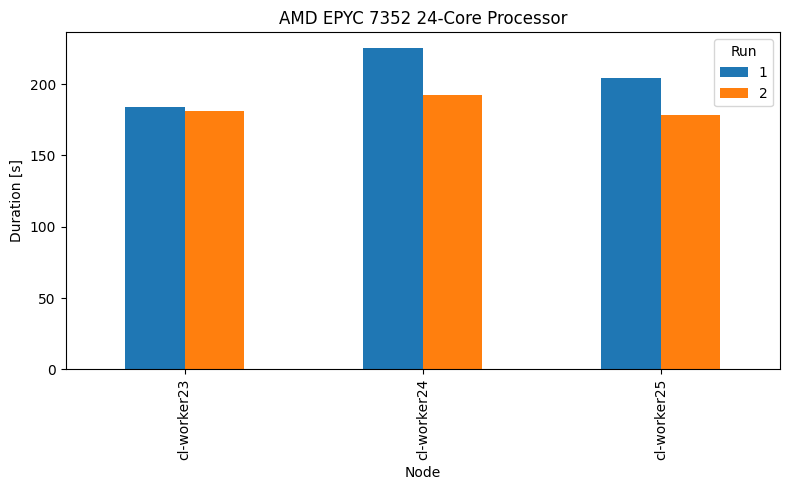

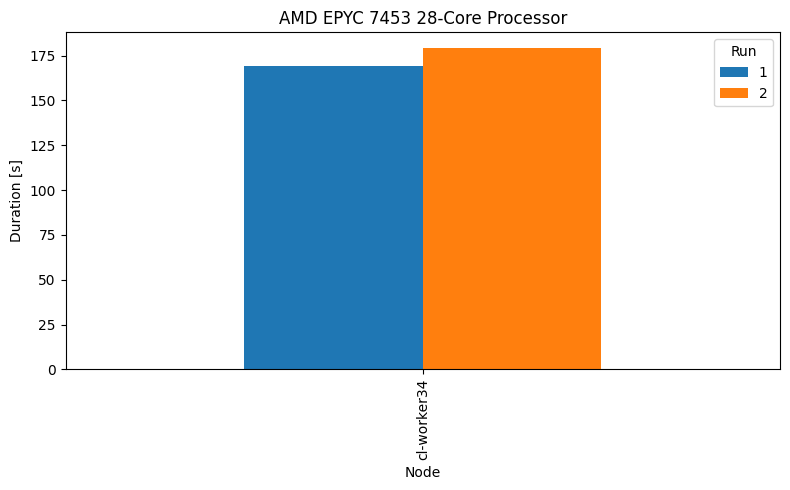

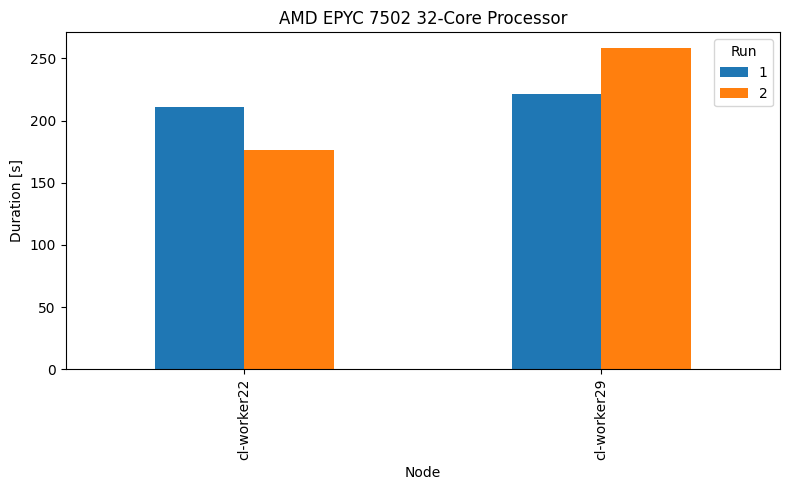

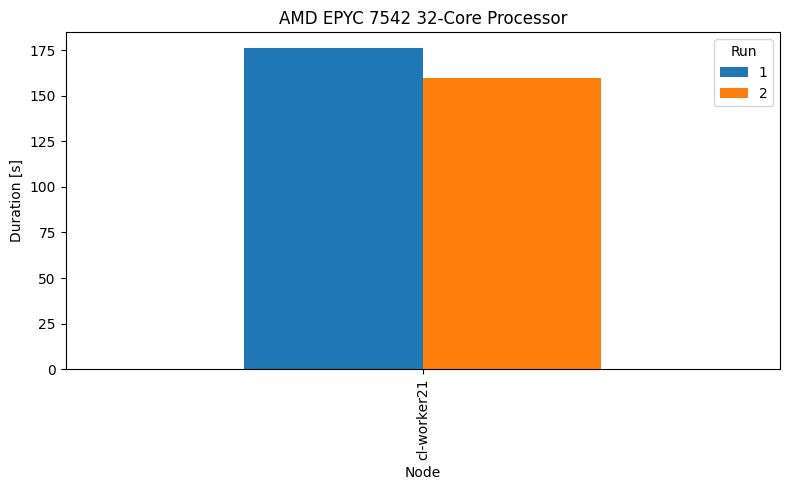

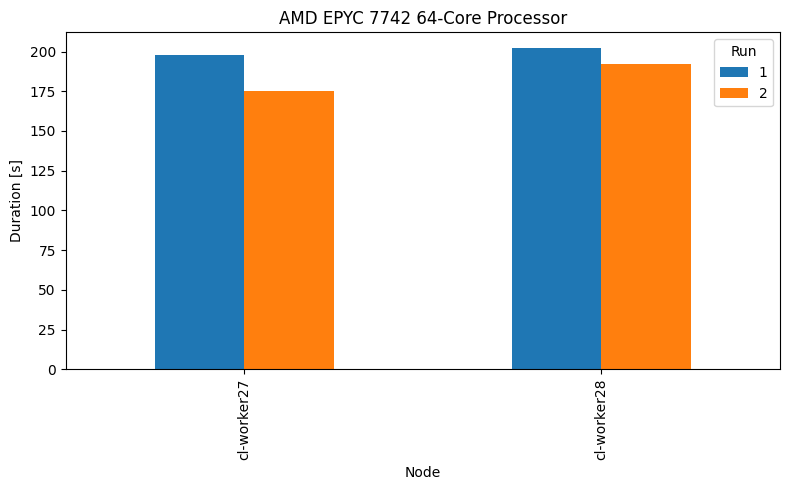

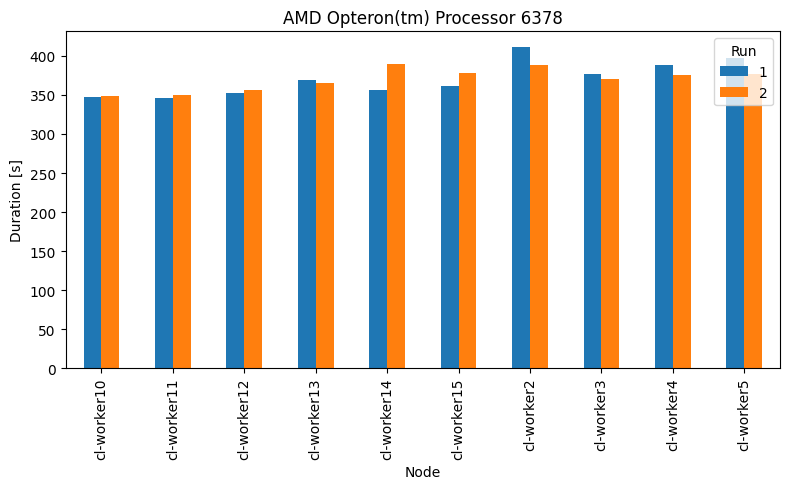

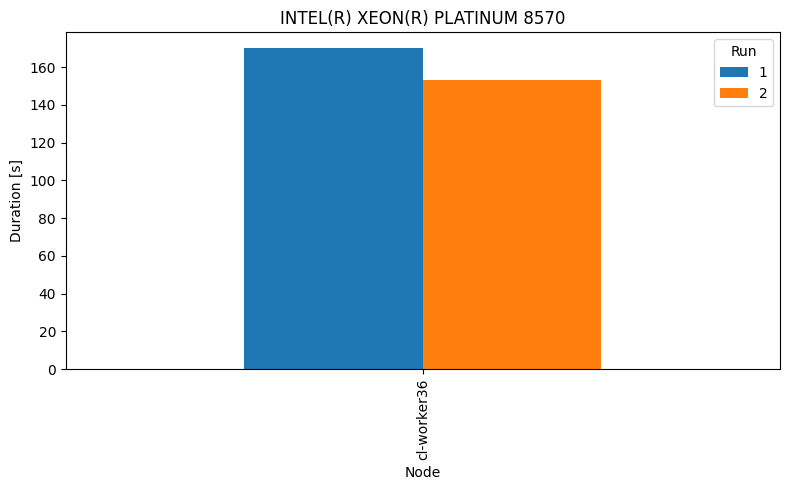

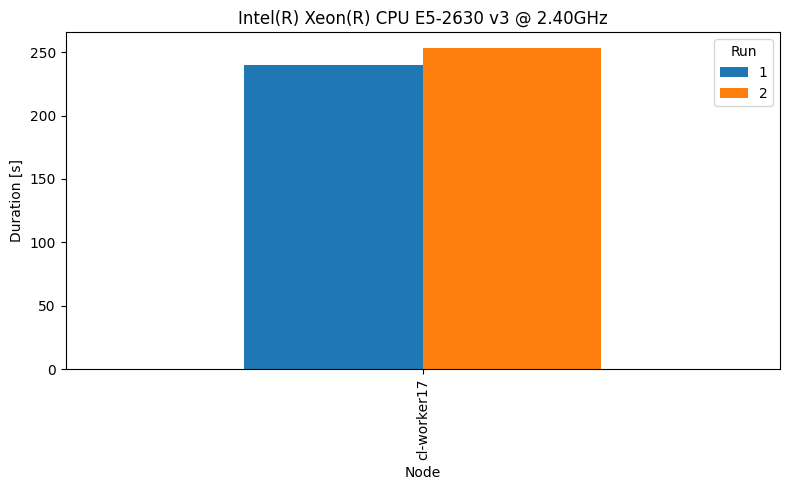

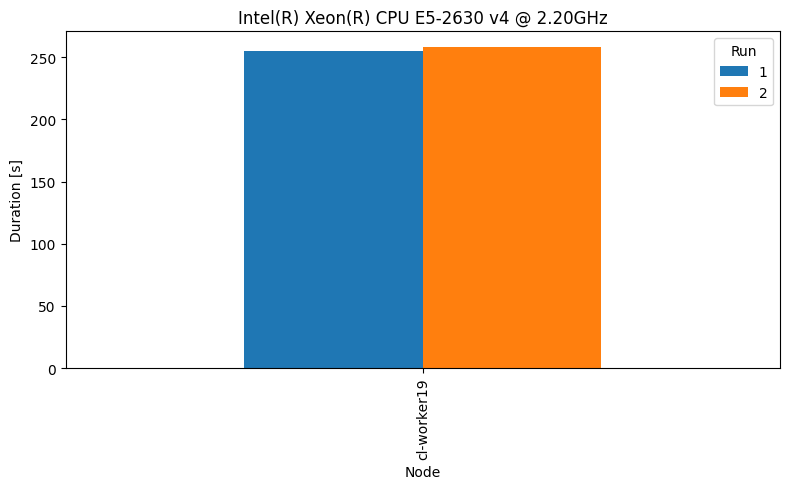

In [56]:
df = df_benchmark.copy()
# Group by CPU
for cpu, cpu_df in df.groupby(level='CPU'):
    # Unstack to get nodes as columns, num_client as x-axis
    cpu_df = cpu_df.droplevel('CPU')
    df_unstacked = cpu_df['span_benchmark'].unstack(level='num_client')

    # Plot
    ax = df_unstacked.plot(kind='bar', figsize=(8, 5), title=cpu)
    ax.set_ylabel("Duration [s]")
    ax.set_xlabel("Node")
    ax.legend(title='Run')
    ax.set_xticks(range(len(df_unstacked.index)))
    ax.set_xticklabels(df_unstacked.index, rotation=90)
    plt.tight_layout()
    plt.show()


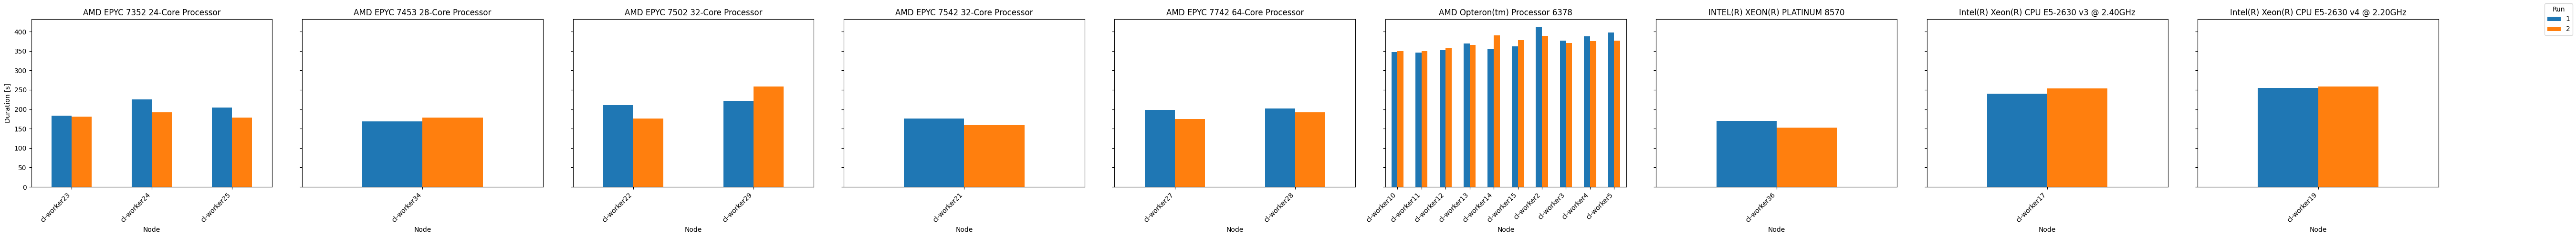

In [57]:
import matplotlib.pyplot as plt

# Get unique CPUs
cpus = df.index.get_level_values('CPU').unique()
n_cpus = len(cpus)

# Create subplots — one row of plots
fig, axes = plt.subplots(nrows=1, ncols=n_cpus, figsize=(6 * n_cpus, 5), sharey=True)

# If only one CPU, axes is not a list — make it iterable
if n_cpus == 1:
    axes = [axes]

# Loop through CPUs and plot into each subplot
for ax, cpu in zip(axes, cpus):
    cpu_df = df.xs(cpu, level='CPU')  # slice data for this CPU
    df_unstacked = cpu_df['span_benchmark'].unstack(level='num_client')

    df_unstacked.plot(kind='bar', ax=ax, legend=False)

    ax.set_title(cpu)
    ax.set_xlabel("Node")
    ax.set_ylabel("Duration [s]")
    ax.set_xticks(range(len(df_unstacked.index)))
    ax.set_xticklabels(df_unstacked.index, rotation=45, ha='right')

# Add one legend for the whole figure
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, title='Run', loc='upper right')

plt.tight_layout(rect=[0, 0, 0.95, 1])  # leave space for legend

# Save to file
plt.savefig("time_per_cpu.png", dpi=300)
plt.show()
plt.close()


In [39]:
df_hw = df_time.copy()
df_hw[['node', 'cpu_total_stream']]

,node,cpu_total_stream
MonetDB-BHT-8-1-1,cl-worker10,624.520229
MonetDB-BHT-8-2-1,cl-worker10,621.852935
MonetDB-BHT-8-1-1,cl-worker11,644.217953
MonetDB-BHT-8-2-1,cl-worker11,637.473144
MonetDB-BHT-8-1-1,cl-worker12,542.273317
MonetDB-BHT-8-2-1,cl-worker12,639.129917
MonetDB-BHT-8-1-1,cl-worker13,653.469596
MonetDB-BHT-8-2-1,cl-worker13,634.911128
MonetDB-BHT-8-1-1,cl-worker14,588.133767
MonetDB-BHT-8-2-1,cl-worker14,612.460159


In [40]:
df_hw = df_time.copy()
df_hw['mem_max_stream'] = df_hw['mem_max_stream']/1024
df_hw[['node', 'mem_max_stream']].sort_values('node')

,node,mem_max_stream
MonetDB-BHT-8-1-1,cl-worker10,90.623775
MonetDB-BHT-8-2-1,cl-worker10,90.007751
MonetDB-BHT-8-1-1,cl-worker11,82.924194
MonetDB-BHT-8-2-1,cl-worker11,82.819611
MonetDB-BHT-8-1-1,cl-worker12,78.122887
MonetDB-BHT-8-2-1,cl-worker12,78.305759
MonetDB-BHT-8-1-1,cl-worker13,84.032692
MonetDB-BHT-8-2-1,cl-worker13,82.870594
MonetDB-BHT-8-1-1,cl-worker14,90.133423
MonetDB-BHT-8-2-1,cl-worker14,89.614075
